In [ ]:
import gymnasium as gym#envitoment simulator for CartPole model
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque #memory access
from itertools import count

import torch #neural network and education
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
env = gym.make("CartPole-v1")#creating the enviroment "CartPole"

is_ipython = 'inline' in matplotlib.get_backend()#backend inline is familiar to ipynb files
if is_ipython:#if we use ipynb then 
    from IPython import display#updating graphics in 1 window

plt.ion()#interactive mode on(graphics are updating automaticly without function plt.show())

device = torch.device( #device to use to educate model
    "cuda" if torch.cuda.is_available() else#NVIDIA GPU is available
    "mps" if torch.backends.mps.is_available() else#Metal Perfomance Shaders(Mac) are available
    "cpu"
)

In [ ]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))#structure that keep the information of 1 Transition

#fields: capacity, memory(deque)
#methods: push,sample(randomly chooses a batch_size of elements from memory), len
class replay_memory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)
#we need this class to save the experiance of our agent(for RL - reinfocement learning)    

In [ ]:
class DQN(nn.Module):#class for description of nn that tries to predict the Q-function value(this classs is basing on torch.nn.Module)
    def __init__(self, n_observations, n_actions): #n_observations - the number of s(states on input) in Q(s,a), n_actions - the number of available actions - a
        super(DQN,self).__init__()#init of nn.Module class
        self.layer1 = nn.Linear(n_observations,128)#creating of matrix (n_obseravations x 128) - first layer and init with random weights 
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128,n_actions)
    #relu - Rectified Linear Unit (ReLU(x)=max(0,x))
    #x - torch.tensor with parameteres of speed and position of the cart, angle and speed of the stick
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    #self.layer3(x) - vector of Q-function values that shows the effectivity of each action

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

#we use e-greedy strategy. so nn can decide is it taking the random Q-value or the result. it helps to try more variants in the begining of education 
BATCH_SIZE = 128 #size of sample
GAMMA = 0.99 #discount value
EPS_START = 0.9#with what value of probability agent will try to guess the right action in the begining of education
EPS_END = 0.05#the final value of probability
EPS_DECAY = 1000#with wich speed the probability will grow
TAU = 0.005#rate of education of target_net 
# if TAU is too big the optim value can be incorrect, if too small - net wont adapt to data
LR = 1e-4#rate of education. if it too big nn will skip the optim value, if too small will not adapt to data
#target_net - central network that works with data (we need it to stabilize the education)
#policy_net - network to choose the action 
n_actions = env.action_space.n #n_actions
state, info = env.reset() #state is information of initial state of enviroment, info is not that usefull for agents
n_observations = len(state)

#copy policy_net's weights to target_net
policy_net = DQN(n_observations,n_actions).to(device)# creating a policy_net, .to(device) is on wich device nn will work
target_net = DQN(n_observations,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())#.state_dict - dictionary of current weights, .load_state_dict - loading the dictionary to target_net

#algorithm Adam stabalize the update of weights with the gradients(use two moments), amsgrad is modification of Adam that stabalize the second momemt
#AdamW is modification of Adam(new and more stable version for deep learning)
#policy_net.parameteres - weights that we need to update
optimizer = optim.AdamW(policy_net.parameters(),lr=LR,amsgrad=True)
memory = replay_memory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()#random number from 1 to 0
    eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1*steps_done/EPS_DECAY)#threshhold value from EPS_START to EPS_END with exp rate(control with EPS_DECAY)

    steps_done+=1
    if sample>eps_threshold:
        with torch.no_grad():
            #policy_net(state) is equal to policy_net.forward(state)
            return policy_net(state).max(1).indices.view(1, 1)# index of max value of Q-func with the correct representation for finding loss 
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)#random index

episode_durations = []

#func for visualization
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)#transform the list of episode_durations to tensor so we can work with average
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:#moving average
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
#func choosing the mini-batch from replay memory and calculate Q-values then corect weights in nn
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


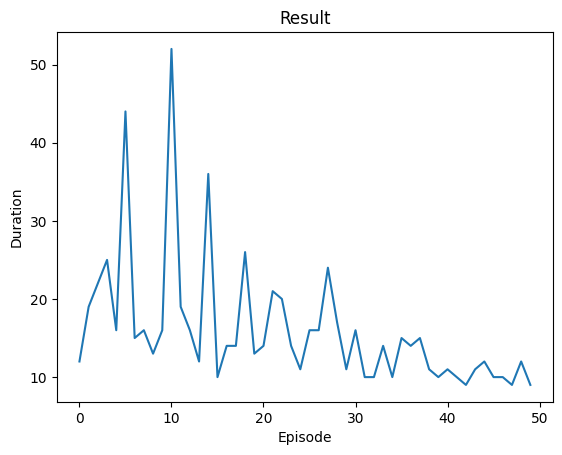

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)#creating a tensor  .unsqueeze(0) - fromat for our batch
    for t in count():#inf cycle
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())#action.item() - index of chosen Q-value, env.step - updating parameteres with this step
        reward = torch.tensor([reward], device=device)#reward->tensor
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)#next_state->tensor

        # Store the transition in memory
        memory.push(state, action, next_state, reward)#adding this transision in replay memory

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()#huber loss

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()#dictionary of the current weights
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:#soft update of target_net weights
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)#updating the dictionary of weights

        if done:
            episode_durations.append(t + 1)
            plot_durations()#updating graphic
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()